In [1]:
# Purpose:
# Use data on fatal hit & runs to predict whether or not the driver was drinking

In [2]:
# Imports and options
import pandas as pd
import numpy as np
import pickle

pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm

%matplotlib inline

/Users/maludee/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Import the cleaned data - includes only hit & runs
with open("hit_run.pkl", 'rb') as picklefile:
    hit_run = pickle.load(picklefile)
    
hit_run.head()

hit_run           drunk_dr_1            drugs_1.0  \
59                  1.00                 1.00                 0.00   
65                  1.00                 1.00                 1.00   
164                 1.00                 0.00                 1.00   
216                 1.00                 0.00                 0.00   
234                 1.00                 0.00                 1.00   

            age_(20, 65]        age_(65, 120]           ve_total_2  \
59                  1.00                 0.00                 0.00   
65                  1.00                 0.00                 0.00   
164                 1.00                 0.00                 1.00   
216                 0.00                 0.00                 0.00   
234                 1.00                 0.00                 0.00   

              ve_total_3           ve_total_4           ve_total_5  \
59                  0.00                 0.00                 0.00   
65                  1.00                 0.00                 0.00   
164                 0.00                 0.00                 0.00   
216                 0.00                 0.00                 0.00   
234                 0.00                 1.00                 0.00   

                  peds_1            permvit_2            permvit_3  \
59                  1.00                 0.00                 0.00   
65                  0.00                 0.00                 0.00   
164                 0.00                 1.00                 0.00   
216                 1.00                 0.00                 0.00   
234                 1.00                 0.00                 0.00   

               permvit_4            permvit_5             fatals_1  \
59                  0.00                 0.00                 0.00   
65                  1.00                 0.00                 0.00   
164                 0.00                 0.00                 0.00   
216                 0.00                 0.00                 0.00   
234                 0.00                 0.00                 0.00   

                deaths_1         month_spring         month_summer  \
59                  1.00                 0.00                 0.00   
65                  1.00                 0.00                 0.00   
164                 1.00                 1.00                 0.00   
216                 1.00                 0.00                 1.00   
234                 1.00                 0.00                 0.00   

            month_winter     day_week_weekend       hour_nighttime  \
59                  1.00                 0.00                 1.00   
65                  1.00                 0.00                 0.00   
164                 0.00                 0.00                 1.00   
216                 0.00                 1.00                 0.00   
234                 0.00                 0.00                 1.00   

                 nhs_1.0          rur_urb_2.0          rur_urb_6.0  \
59                  0.00                 1.00                 0.00   
65                  1.00                 1.00                 0.00   
164                 1.00                 1.00                 0.00   
216                 0.00                 1.00                 0.00   
234                 0.00                 1.00                 0.00   

       harm_ev_inanimate  harm_ev_ped or cyclist        harm_ev_train  \
59                  0.00                    1.00                 0.00   
65                  0.00                    0.00                 0.00   
164                 0.00                    0.00                 0.00   
216                 0.00                    1.00                 0.00   
234                 0.00                    1.00                 0.00   

         harm_ev_vehicle         man_coll_1.0         man_coll_2.0  \
59                  0.00                 0.00                 0.00   
65                  1.00                 0.00                 0.00   


In [4]:
# Move the gender column to the left since it is a driver attribute and won't be used as a feature
cols = list(hit_run)
cols.insert(0, cols.pop(cols.index('sex_2.0')))
hit_run = hit_run.ix[:, cols]

In [5]:
# Move drunk_dr to the left so it can be the Y variable 
cols = list(hit_run)
cols.insert(0, cols.pop(cols.index('drunk_dr_1')))
hit_run = hit_run.ix[:, cols]
hit_run.head(3)

drunk_dr_1              sex_2.0              hit_run  \
59                  1.00                 0.00                 1.00   
65                  1.00                 0.00                 1.00   
164                 0.00                 0.00                 1.00   

               drugs_1.0         age_(20, 65]        age_(65, 120]  \
59                  0.00                 1.00                 0.00   
65                  1.00                 1.00                 0.00   
164                 1.00                 1.00                 0.00   

              ve_total_2           ve_total_3           ve_total_4  \
59                  0.00                 0.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 1.00                 0.00                 0.00   

              ve_total_5               peds_1            permvit_2  \
59                  0.00                 1.00                 0.00   
65                  0.00                 0.00                 0.00   
164                 0.00                 0.00                 1.00   

               permvit_3            permvit_4            permvit_5  \
59                  0.00                 0.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 0.00                 0.00   

                fatals_1             deaths_1         month_spring  \
59                  0.00                 1.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 1.00                 1.00   

            month_summer         month_winter     day_week_weekend  \
59                  0.00                 1.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 0.00                 0.00   

          hour_nighttime              nhs_1.0          rur_urb_2.0  \
59                  1.00                 0.00                 1.00   
65                  0.00                 1.00                 1.00   
164                 1.00                 1.00                 1.00   

             rur_urb_6.0    harm_ev_inanimate  harm_ev_ped or cyclist  \
59                  0.00                 0.00                    1.00   
65                  0.00                 0.00                    0.00   
164                 0.00                 0.00                    0.00   

           harm_ev_train      harm_ev_vehicle         man_coll_1.0  \
59                  0.00                 0.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 1.00                 1.00   

            man_coll_2.0         man_coll_6.0         man_coll_7.0  \
59                  0.00                 0.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 0.00                 0.00   

            man_coll_8.0         man_coll_9.0        man_coll_10.0  \
59                  0.00                 0.00                 0.00   
65                  0.00                 0.00                 0.00   
164                 0.00                 0.00                 0.00   

           man_coll_11.0         weather_good         body_typ_bus  \
59                  0.00                 1.00                 0.00   
65                  0.00                 1.00                 0.00   
164                 0.00                 1.00                 0.00   

            body_typ_car  body_typ_convertible  body_typ_motorcycle  \
59                  1.00                  0.00                 0.00   
65                  0.00                  0.00                 0.00   
164                 1.00                  0.00                 0.00   

          body_typ_other  body_typ_pickup truck  body_typ_van or

In [6]:
# Drop columns that wouldn't be known if the driver was missing
hit_run = hit_run.drop('l_status_valid', 1)
hit_run = hit_run.drop('cdl_stat_valid', 1)
hit_run = hit_run.drop('l_restri_1.0', 1)
hit_run = hit_run.drop('l_restri_2.0', 1)
hit_run = hit_run.drop('l_restri_3.0', 1)
hit_run = hit_run.drop('prev_acc_1.0', 1)
hit_run = hit_run.drop('prev_sus_1.0', 1)
hit_run = hit_run.drop('prev_dwi_1.0', 1)
hit_run = hit_run.drop('prev_spd_1.0', 1)
hit_run = hit_run.drop('prev_oth_1.0', 1)


In [7]:
# Set X and y
y = hit_run.ix[:,0]
X = hit_run.ix[:,6:]

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444, stratify=y)

# Random Forest
forest_model = RandomForestClassifier(max_depth = 5, n_estimators = 10)
result = forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)
test = forest_model.score(X_test, y_test)
train = forest_model.score(X_train, y_train)

print "Random forest:", train, test
print "precision:", precision_score(y_pred, y_test)
print "recall:", recall_score(y_pred, y_test)
print "F1:", f1_score(y_pred, y_test)
print "confusion matrix on whole:", confusion_matrix(y_test, y_pred)

features = zip(X.columns, forest_model.feature_importances_)
sorted(features, key = lambda x: x[1], reverse = True)

Random forest: 0.737556561086 0.677083333333
precision: 0.477272727273
recall: 0.724137931034
F1: 0.575342465753
confusion matrix on whole: [[44  8]
 [23 21]]


[(u'hour_nighttime', 0.15817991205460299),
 (u'peds_1', 0.080878066174846414),
 (u'speedrel_speeding', 0.066367164870718379),
 (u'body_typ_van or SUV', 0.050874198818029737),
 (u'body_typ_pickup truck', 0.049485170497345556),
 (u'vtcont_f_3.0', 0.041960881453233692),
 (u'harm_ev_vehicle', 0.040306480205393),
 (u'rur_urb_2.0', 0.037516530467618284),
 (u'permvit_4', 0.035228187917013751),
 (u'permvit_5', 0.033732327847560986),
 (u'man_coll_6.0', 0.030604256295222586),
 (u'permvit_2', 0.028123667844263272),
 (u'harm_ev_ped or cyclist', 0.027352285753190753),
 (u'man_coll_1.0', 0.026400376148993016),
 (u've_total_2', 0.026215622973979634),
 (u'harm_ev_inanimate', 0.025560321724197883),
 (u'permvit_3', 0.025315996870775535),
 (u'month_winter', 0.023149754918233116),
 (u'month_spring', 0.020580472053603548),
 (u'body_typ_car', 0.020421463421154813),
 (u'vsurcond_dry', 0.018400033187223361),
 (u'vsurcond_wet', 0.018130713310168758),
 (u'fire_exp_1', 0.014573839084198062),
 (u'fatals_1', 0.013

Confusion matrix, without normalization
[[44  8]
 [23 21]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.52  0.48]]


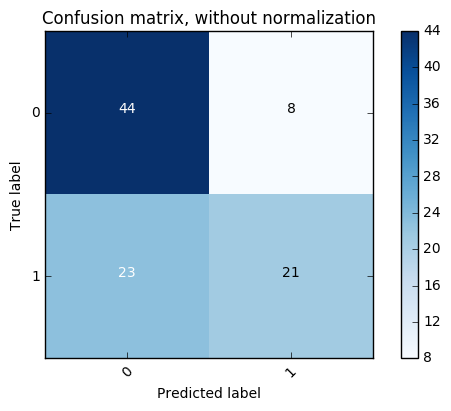

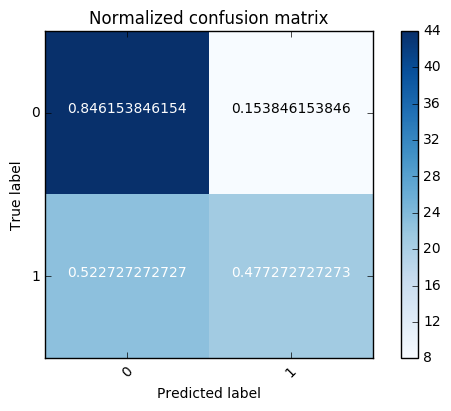

In [8]:
# Plot confusion matrices

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Optimal number of features : 11


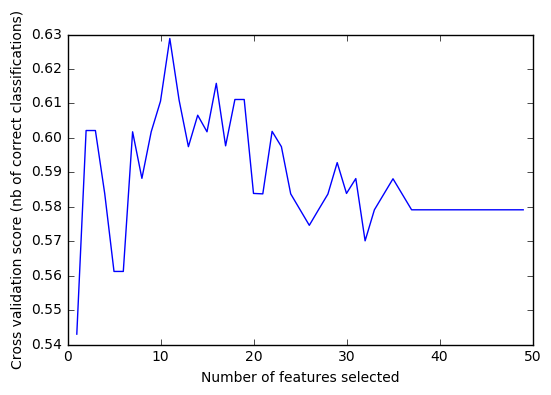

In [9]:
# Check how many features are optimal?

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [10]:
# Fit the log model & print out score
log_model = LogisticRegression()
result = log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
test_score = log_model.score(X_test, y_test)
train_score = log_model.score(X_train, y_train)

print "log model:", train_score, test_score
print "precision:", precision_score(y_pred, y_test)
print "recall:", recall_score(y_pred, y_test)
print "F1:", f1_score(y_pred, y_test)




log model: 0.683257918552 0.583333333333
precision: 0.477272727273
recall: 0.552631578947
F1: 0.512195121951
